# LGBM을 활용한 베이스라인

In [2]:
import pandas as pd
import os
import random

## 1. 데이터 로딩

In [3]:
data_dir = '/opt/ml/input/data/'
csv_file_path = os.path.join(data_dir, 'train_data.csv')
df = pd.read_csv(csv_file_path) 

## 2. Feature Engineering

In [4]:
import pandas as pd
import os
import random
import seaborn as sns
import matplotlib.pyplot as plt
import time
from datetime import datetime

def convert_time2timestamp(t):
    timestamp = time.mktime(t.timetuple())
    return int(timestamp)

def convert_string2datetime(s: str):
    return datetime.strptime(s, "%Y-%m-%d %H:%M:%S")

def fe(df):
    ## 문자열로 인식되는 Timestamp의 타입을 datetime으로 변경하기. 
    print('Timestamp feature engineering start ..')
    df["Timestamp"] = df["Timestamp"].apply(convert_string2datetime) # string type to datetime type


    ## 기본적인 시간정보 추가
    df['year'] = df['Timestamp'].dt.year
    df['month'] = df['Timestamp'].dt.month
    df['day'] = df['Timestamp'].dt.day
    df['hour'] = df['Timestamp'].dt.hour                                       # 시간대로 범주 추가 가능


    ## 요일 추가
    df['wday'] = df['Timestamp'].dt.weekday # Monday ~ Sunday => 0 ~ 6         # 주말로 범주 추가 가능
    

    ## 문제를 다시 풀어본 횟수 feature 'retry' 추가
    test_group = df.groupby(['userID','testId']) # 같은 시험지끼리 묶어준다.
    # retry_check = 0
    retry_df = pd.DataFrame()
    for key, group in test_group:
        if len(group[group.assessmentItemID == group.assessmentItemID.iloc[0]]) >= 2:
            retry_df = pd.concat([retry_df,group.groupby('assessmentItemID').cumcount()])
            # retry_check += 1
    retry_df.columns=['retry']
    df = pd.merge(df, retry_df, left_index=True,right_index=True, how="left")
    df['retry'] = df['retry'].fillna(0) # retry의 결측치(한 번만 푼 문제들)을 0으로 바꿔준다.

    
    ## 문제 풀이 시간 추가
    df['time'] = df['time'] = df.groupby(['userID','testId','retry'])['Timestamp'].diff().shift(-1) # 문제 풀이 시간
    df['time'] = df['time'].fillna(df['time'].median())                        # Null값은 중앙값으로 채우기.
    df['time'] = df['time'].apply(lambda x:x.total_seconds())                  # 년,월,일,날짜로 되어있는 값을 시간초로 변환
    df['time'] = df['time'].apply(lambda x:300 if x > 300 else x)              # 최댓값을 300으로 변환.


    ## 문제 풀이 시간 그룹 추가
    time_ranges = [-0.001,5,18,27,37,80,300]
    df['time_class'] = pd.cut(df['time'],time_ranges,labels=[0,1,2,3,4,5])
    
    ## 문제 풀이 시간 그룹별 통계량 추가
    time_class_stat = df[df['userID'].shift(1) == df['userID']].groupby(['time_class'])['answerCode'].agg(['mean','sum','std'])
    time_class_stat.columns = ['time_class_mean', 'time_class_sum', 'time_class_std']
    df = pd.merge(df,time_class_stat,on=['time_class'],how='left')


    ## 전체적인 시간정보를 나타내는 Timestamp는 int형으로 변환.
    df["Timestamp"] = df["Timestamp"].apply(convert_time2timestamp) # datetime to timestamp
    print(' Done.')
    print('TestID feature engineering start ..',end='')
    ## 시험지의 평균 정답률, 정답 개수, 표준편차
    correct_t = df[df['userID'].shift(1) == df['userID']].groupby(['testId'])['answerCode'].agg(['mean', 'sum','std'])
    correct_t.columns = ["test_ans_mean", 'test_ans_sum','test_ans_std']
    df = pd.merge(df, correct_t, on=['testId'], how="left")

    ## 시험지의 평균 풀이 시간, 표준편차
    time_t = df.groupby(['testId'])['time'].agg(['mean', 'std'])
    time_t.columns = ["test_time_mean", 'test_time_std']
    df = pd.merge(df, time_t, on=['testId'], how="left")


    ## 시험지 대분류(test_type) 생성
    df['test_type'] = df['testId'].apply(lambda x:int(x[2]))

    ## 시험지 대분류별 정답률, 정답 개수, 표준편차
    correct_type = df[df['userID'].shift(1) == df['userID']].groupby(['test_type'])['answerCode'].agg(['mean', 'sum','std'])
    correct_type.columns = ["t_type_ans_mean", 't_type_ans_sum','t_type_ans_std']
    df = pd.merge(df, correct_type, on=['test_type'], how="left")

    ## 시험지 대분류별 풀이시간, 표준편차
    time_type = df.groupby(['test_type'])['time'].agg(['mean', 'std'])
    time_type.columns = ["t_type_time_mean", 't_type_time_std']
    df = pd.merge(df, time_type, on=['test_type'], how="left")

    ## 시험지 난이도
    df['test_lvl'] = df['test_time_mean'] / df['test_ans_mean']
    # 범주화
    cat_num = 10
    df['test_lvl_cat'] = pd.qcut(df['test_lvl'],cat_num,labels=[i for i in range(cat_num)])

    ## 시험지 대분류별 난이도
    # 난이도를 나타내는 척도는 임의로 풀이시간 평균 / 평균 정답률로 설정.
    # 풀이시간이 길어지면 난이도가 높아지고, 정답률이 낮아지면 난이도가 높아진다.
    df['test_type_lvl'] = df['t_type_time_mean'] / df['t_type_ans_mean']

    # 범주화
    type_cat_num = 3
    df['test_type_lvl_cat'] = pd.qcut(df['test_type_lvl'],type_cat_num,labels=[i for i in range(type_cat_num)])

    ## 시험지 노출 횟수
    df['test_total_answer'] = df.groupby('testId')['answerCode'].cumcount()

    print('TagID feature engineering start ..',end='')
    ## tag의 평균 정답률, 정답 총합, 표준편차
    correct_k = df[df['userID'].shift(1) == df['userID']].groupby(['KnowledgeTag'])['answerCode'].agg(['mean', 'sum','std'])
    correct_k.columns = ["tag_ans_mean", 'tag_ans_sum','tag_ans_std']
    df = pd.merge(df, correct_k, on=['KnowledgeTag'], how="left")
    
    ## 태그의 평균 풀이 시간, 표준편차
    time_k = df.groupby(['KnowledgeTag'])['time'].agg(['mean', 'std'])
    time_k.columns = ["tag_time_mean", 'tag_time_std']
    df = pd.merge(df, time_k, on=['KnowledgeTag'], how="left")

    ## 태그 난이도
    df['tag_lvl'] = df['tag_time_mean'] / df['tag_ans_mean']

    # 범주화
    tag_cat_num = 10
    df['tag_lvl_cat'] = pd.qcut(df['tag_lvl'],tag_cat_num,labels=[i for i in range(tag_cat_num)])

    ## 태그 노출 횟수
    df['tag_total_answer'] = df.groupby('KnowledgeTag')['answerCode'].cumcount()
    print(' Done.')
    print('UserID feature engineering start ..',end='')
    #유저들의 문제 풀이수, 정답 수, 정답률을 시간순으로 누적해서 계산
    df['user_ans_1'] = df[df['userID'].shift(1) == df['userID']].groupby('userID')['answerCode'].transform(lambda x:x.cumsum().shift(1))
    df['user_total_ans'] = df.groupby('userID')['answerCode'].cumcount()
    df['user_acc'] = df['user_ans_1']/df['user_total_ans']

    df['user_test_ans_count'] = df.groupby(['userID','testId'])['answerCode'].cumcount()
    df['user_test_ans_1'] = df[df['userID'].shift(1) == df['userID']].groupby(['userID','testId'])['answerCode'].transform(lambda x:x.cumsum().shift(1))
    df['user_test_acc'] = df['user_test_ans_1'] / df['user_test_ans_count']
    df['user_test_lvl_mean'] = df.groupby(['userID'])['test_lvl'].cumsum() / (df.user_total_ans + 1)

    df['user_tag_ans_count'] = df.groupby(['userID','KnowledgeTag'])['answerCode'].cumcount()
    df['user_tag_ans_1'] = df[df['userID'].shift(1) == df['userID']].groupby(['userID','KnowledgeTag'])['answerCode'].transform(lambda x:x.cumsum().shift(1))
    df['user_tag_acc'] = df['user_tag_ans_1'] / df['user_tag_ans_count']
    df['user_tag_lvl_mean'] = df.groupby(['userID'])['tag_lvl'].cumsum() / (df.user_total_ans + 1)

    df['user_lvl'] = df.user_tag_lvl_mean + df.user_test_lvl_mean


    df['item_ans_1'] = df[df['userID'].shift(1) == df['userID']].groupby('assessmentItemID')['answerCode'].transform(lambda x:x.cumsum().shift(1))
    df['item_total_ans'] = df.groupby('assessmentItemID')['answerCode'].cumcount()
    df['item_acc'] = df['item_ans_1']/df['item_total_ans']
    
    print(' Done.')
    print('ItemID feature engineering start ..',end='')
    ## item의 평균 정답률, 정답 총합, 표준편차
    correct_a = df.groupby(['assessmentItemID'])['answerCode'].agg(['mean', 'sum','std'])
    correct_a.columns = ["item_ans_mean", 'item_ans_sum','item_ans_std']
    df = pd.merge(df, correct_a, on=['assessmentItemID'], how="left")
    
    ## item의 평균 풀이 시간, 표준편차
    time_a = df.groupby(['assessmentItemID'])['time'].agg(['mean', 'std'])
    time_a.columns = ["item_time_mean", 'item_time_std']
    df = pd.merge(df, time_a, on=['assessmentItemID'], how="left")

    # ## item 난이도
    # df['item_lvl'] = df['item_time_mean'] / df['item_ans_mean']
    # # 범주화
    # item_cat_num = 10
    # df['item_lvl_cat'] = pd.qcut(df['item_lvl'],item_cat_num,labels=[i for i in range(item_cat_num)])

    ## item 노출 횟수
    df['item_total_answer'] = df.groupby('assessmentItemID')['answerCode'].cumcount()
    
    df = df.fillna(0)
    print(' Done.')
    return df

In [5]:
df = fe(df)

Timestamp feature engineering start ..
 Done.
TestID feature engineering start ..TagID feature engineering start .. Done.
UserID feature engineering start .. Done.
ItemID feature engineering start .. Done.


In [ ]:
df.columns

Index(['userID', 'assessmentItemID', 'testId', 'answerCode', 'Timestamp',
       'KnowledgeTag', 'year', 'month', 'day', 'hour', 'wday', 'retry', 'time',
       'time_class', 'time_class_mean', 'time_class_sum', 'time_class_std',
       'test_ans_mean', 'test_ans_sum', 'test_ans_std', 'test_time_mean',
       'test_time_std', 'test_type', 't_type_ans_mean', 't_type_ans_sum',
       't_type_ans_std', 't_type_time_mean', 't_type_time_std', 'test_lvl',
       'test_lvl_cat', 'test_type_lvl', 'test_type_lvl_cat',
       'test_total_answer', 'tag_ans_mean', 'tag_ans_sum', 'tag_ans_std',
       'tag_time_mean', 'tag_time_std', 'tag_lvl', 'tag_lvl_cat',
       'tag_total_answer', 'user_ans_1', 'user_total_ans', 'user_acc',
       'user_test_ans_count', 'user_test_ans_1', 'user_test_acc',
       'user_test_lvl_mean', 'user_tag_ans_count', 'user_tag_ans_1',
       'user_tag_acc', 'user_tag_lvl_mean', 'user_lvl', 'item_ans_1',
       'item_total_ans', 'item_acc', 'item_ans_mean', 'item_ans_sum',

## 3. Train/Test 데이터 셋 분리

In [6]:
# train과 test 데이터셋은 사용자 별로 묶어서 분리를 해주어야함
random.seed(42)
def custom_train_test_split(df, ratio=0.7, split=True):
    
    users = list(zip(df['userID'].value_counts().index, df['userID'].value_counts()))
    random.shuffle(users)
    
    max_train_data_len = ratio*len(df)
    sum_of_train_data = 0
    user_ids =[]

    for user_id, count in users:
        sum_of_train_data += count
        if max_train_data_len < sum_of_train_data:
            break
        user_ids.append(user_id)


    train = df[df['userID'].isin(user_ids)]
    test = df[df['userID'].isin(user_ids) == False]

    #test데이터셋은 각 유저의 마지막 interaction만 추출
    test = test[test['userID'] != test['userID'].shift(-1)]
    return train, test

In [7]:
df.select_dtypes(include=['object'])

,assessmentItemID,testId
0,A060001001,A060000001
1,A060001002,A060000001
2,A060001003,A060000001
3,A060001004,A060000001
4,A060001005,A060000001
...,...,...
2266581,A030071005,A030000071
2266582,A040165001,A040000165
2266583,A040165002,A040000165
2266584,A040165003,A040000165


In [8]:
# 유저별 분리
train, test = custom_train_test_split(df)

# 사용할 Feature 설정
FEATS = ['Timestamp',
       'KnowledgeTag', 'year', 'month', 'day', 'hour', 'wday', 'retry', 'time',
       'time_class', 'time_class_mean', 'time_class_sum', 'time_class_std',
       'test_ans_mean', 'test_ans_sum', 'test_ans_std', 'test_time_mean',
       'test_time_std', 'test_type', 't_type_ans_mean', 't_type_ans_sum',
       't_type_ans_std', 't_type_time_mean', 't_type_time_std', 'test_lvl',
       'test_lvl_cat', 'test_type_lvl', 'test_type_lvl_cat',
       'test_total_answer', 'tag_ans_mean', 'tag_ans_sum', 'tag_ans_std',
       'tag_time_mean', 'tag_time_std', 'tag_lvl', 'tag_lvl_cat',
       'tag_total_answer', 'user_ans_1', 'user_total_ans', 'user_acc',
       'user_test_ans_count', 'user_test_ans_1', 'user_test_acc',
       'user_test_lvl_mean', 'user_tag_ans_count', 'user_tag_ans_1',
       'user_tag_acc', 'user_tag_lvl_mean', 'user_lvl', 'item_ans_1',
       'item_total_ans', 'item_acc', 'item_ans_mean', 'item_ans_sum',
       'item_ans_std', 'item_time_mean', 'item_time_std', 'item_total_answer']

# X, y 값 분리
y_train = train['answerCode']
train = train.drop(['answerCode'], axis=1)

y_test = test['answerCode']
test = test.drop(['answerCode'], axis=1)

In [28]:
import lightgbm as lgb
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import f_regression, SelectKBest, chi2, f_classif
import numpy as np

In [119]:
selector = SelectKBest(score_func=f_classif, k=25)
train_selected = selector.fit_transform(train[FEATS],y_train)
test_selected = selector.fit_transform(test[FEATS],y_test)

train_selected.shape,test_selected.shape

/opt/conda/envs/gcn/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [2] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/envs/gcn/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw
/opt/conda/envs/gcn/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:112: UserWarning: Features [ 2  8  9 11] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/opt/conda/envs/gcn/lib/python3.10/site-packages/sklearn/feature_selection/_univariate_selection.py:113: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


((1586157, 25), (2007, 25))

In [120]:
selector.get_feature_names_out()

array(['test_ans_mean', 'test_ans_std', 'test_time_std', 'test_type',
       't_type_ans_mean', 't_type_ans_sum', 't_type_ans_std',
       't_type_time_std', 'test_lvl', 'test_lvl_cat', 'test_type_lvl',
       'tag_ans_mean', 'tag_ans_sum', 'tag_ans_std', 'tag_lvl',
       'tag_lvl_cat', 'user_acc', 'user_test_ans_1', 'user_test_acc',
       'user_tag_ans_1', 'user_tag_acc', 'item_ans_1', 'item_acc',
       'item_ans_mean', 'item_ans_sum'], dtype=object)

In [121]:
lgb_train = lgb.Dataset(train_selected, y_train)
lgb_test = lgb.Dataset(test_selected, y_test)

## 4. 훈련 및 검증

In [122]:
# params = {
#           'bagging_freq': 1, 
#         #   'verbosity': -1, 
#           'num_iterations': 1000,
#           # 'seed': 42, 
#           # 'feature_pre_filter': False,
#           'objective': 'binary', 
#           'metric': 'binary_logloss',
#         #   'boosting': 'gbdt',
#           'bagging_fraction': 0.7, # 정확도 조금 올라감
#           'feature_fraction': 0.5, # 올리니 떨어짐
#         #   'lambda_l1': 3,
#         #   'lambda_l2': 5,
#           'learning_rate': 0.1, # 낮추니 떨어짐
#           # 'max_depth': 10, # 추가하니 떨어짐
#           # 'min_child_samples': 10,
#           # 'num_leaves': 200, # 추가하니 떨어짐
#           }
params={'objective':'binary'}

In [123]:
model = lgb.train(
    params, 
    lgb_train,
    valid_sets=[lgb_train, lgb_test],
    verbose_eval=100,
    num_boost_round=500,
    early_stopping_rounds=100
)

preds = model.predict(test_selected)
acc = accuracy_score(y_test, np.where(preds >= 0.5, 1, 0))
auc = roc_auc_score(y_test, preds)

print(f'VALID AUC : {auc} ACC : {acc}\n')

/opt/conda/envs/gcn/lib/python3.10/site-packages/lightgbm/engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
/opt/conda/envs/gcn/lib/python3.10/site-packages/lightgbm/engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Info] Number of positive: 1039565, number of negative: 546592
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.021994 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 3615
[LightGBM] [Info] Number of data points in the train set: 1586157, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.655399 -> initscore=0.642855
[LightGBM] [Info] Start training from score 0.642855
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.460092	valid_1's binary_logloss: 0.609316
Early stopping, best iteration is:
[60]	training's binary_logloss: 0.462666	valid_1's binary_logloss: 0.602647
VALID AUC : 0.7692039355992845 ACC : 0.6965620328849028



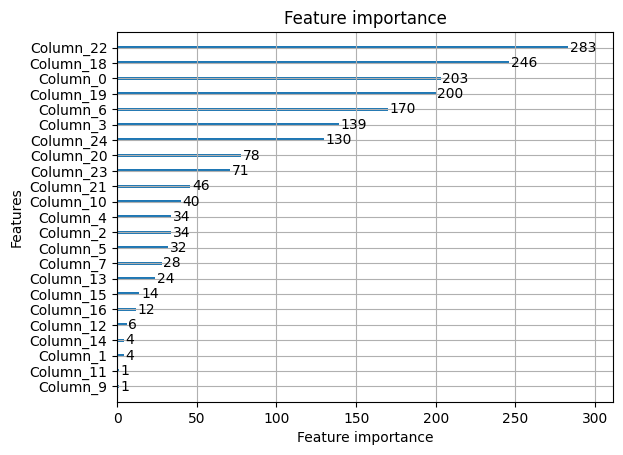

In [124]:
# INSTALL MATPLOTLIB IN ADVANCE
_ = lgb.plot_importance(model)

## 5. Inference

In [84]:
# LOAD TESTDATA
test_csv_file_path = os.path.join(data_dir, 'test_data.csv')
test_df = pd.read_csv(test_csv_file_path)

# FEATURE ENGINEERING
test_df = fe(test_df)

# LEAVE LAST INTERACTION ONLY
test_df = test_df[test_df['userID'] != test_df['userID'].shift(-1)]

# DROP ANSWERCODE
test_df = test_df.drop(['answerCode'], axis=1)

Timestamp feature engineering start ..
 Done.
TestID feature engineering start ..

/opt/conda/envs/gcn/lib/python3.10/site-packages/numpy/lib/function_base.py:4573: RuntimeWarning: invalid value encountered in subtract
  diff_b_a = subtract(b, a)


TagID feature engineering start .. Done.
UserID feature engineering start .. Done.
ItemID feature engineering start .. Done.


In [37]:
# with pd.option_context('display.max_rows', None, 'display.max_columns', None):
#     print(test_df[test_df['userID'] != test_df['userID'].shift(-1)].head(2).T)

In [125]:
test_df_selected = selector.transform(test_df[FEATS])
test_df_selected.shape

(744, 25)

In [126]:
# MAKE PREDICTION
total_preds = model.predict(test_df_selected)
total_preds.mean()

0.5163380771578968

In [127]:
# SAVE OUTPUT
output_dir = 'output/'
now = time.localtime()
now_date = time.strftime('%Y%m%d', now)
now_hour = time.strftime('%X', now)
save_time = now_date + '_' + now_hour.replace(':', '')

fname = '{}_{}_{}_{}.csv'.format(save_time,"LGBM",auc.round(4),acc.round(4))
write_path = os.path.join(output_dir, fname)
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
with open(write_path, 'w', encoding='utf8') as w:
    print("writing prediction : {}".format(write_path))
    w.write("id,prediction\n")
    for id, p in enumerate(total_preds):
        w.write('{},{}\n'.format(id,p))

writing prediction : output/20230520_145912_LGBM_0.7692_0.6966.csv
